<a href="https://www.kaggle.com/code/shedai/llm-attention-dersi?scriptVersionId=248057768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Basis (Q, K, V Matrisleri)

In [2]:
import numpy as np

# --- Fonksiyonlar ---
def softmax(x):
    """Numerik olarak stabil bir softmax hesaplamasÄ±."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def print_attention(tokens, attention_matrix):
    """Dikkat matrisini okunaklÄ± bir ÅŸekilde yazdÄ±rÄ±r."""
    header = "         " + "  ".join([f"{token:<8}" for token in tokens])
    print(header)
    print("-" * len(header))
    for i, token in enumerate(tokens):
        row_str = f"{token:<9}"
        for val in attention_matrix[i]:
            row_str += f"{val:.4f}  "
        print(row_str)
    print("\n")

# --- AdÄ±m 0: BaÅŸlangÄ±Ã§ AyarlarÄ± ---
print("--- BAÅžLANGIÃ‡: RASTGELE MATRÄ°SLER ---")
# Model ve vektÃ¶r boyutlarÄ±
d_model = 4
d_k = 3
np.random.seed(42) # Tekrarlanabilirlik iÃ§in

# BAÅžLANGIÃ‡TAKÄ° RASTGELE AÄžIRLIK MATRÄ°SLERÄ°
# Bu matrisler tÃ¼m eÄŸitim sÃ¼reci boyunca gÃ¼ncellenecek.
W_q = np.random.rand(d_model, d_k)
W_k = np.random.rand(d_model, d_k)
W_v = np.random.rand(d_model, d_k) # Bu simÃ¼lasyonda W_v'yi sabit tutacaÄŸÄ±z

print("BaÅŸlangÄ±Ã§ W_q Matrisi:\n", np.round(W_q, 2))
print("\nBaÅŸlangÄ±Ã§ W_k Matrisi:\n", np.round(W_k, 2), "\n")
print("="*50)

# --- AdÄ±m 1: EÄŸitim SimÃ¼lasyonu ---
# Basit bir eÄŸitim veri seti ve hedefler
egitim_verisi = [
    {"metin": "akÄ±llÄ± kÃ¶pek topu getirdi", "kaynak_idx": 1, "hedef_idx": 3}, # kÃ¶pek -> getirdi
    {"metin": "yorgun kedi minderde uyudu", "kaynak_idx": 1, "hedef_idx": 3}, # kedi -> uyudu
]

iterasyon_sayisi = 2
ogrenme_orani = 0.1 # Matrisleri ne kadar deÄŸiÅŸtireceÄŸimizi belirler

for i in range(iterasyon_sayisi):
    print(f"\n########### ITERASYON {i+1} ###########\n")
    
    for veri in egitim_verisi:
        metin = veri["metin"]
        kaynak_idx = veri["kaynak_idx"]
        hedef_idx = veri["hedef_idx"]
        tokenler = metin.split()
        
        print(f"--- Girdi Metni: '{metin}' ---")
        print(f"Hedef: '{tokenler[kaynak_idx]}' kelimesi '{tokenler[hedef_idx]}' kelimesine dikkat etsin.\n")
        
        # 1. Her girdi iÃ§in rastgele kelime vektÃ¶rleri (embedding) oluÅŸtur
        X = np.random.rand(len(tokenler), d_model)
        
        # 2. Ä°leri YayÄ±lÄ±m (Forward Pass) - Mevcut matrislerle dikkat skorlarÄ±nÄ± hesapla
        Q = np.dot(X, W_q)
        K = np.dot(X, W_k)
        
        skorlar = np.dot(Q, K.T) / np.sqrt(d_k)
        dikkat_agirliklari = softmax(skorlar)
        
        print(f"--- GÃœNCELLEME Ã–NCESÄ° DÄ°KKAT MATRÄ°SÄ° (Ä°terasyon {i+1}) ---")
        print_attention(tokenler, dikkat_agirliklari)
        
        # 3. Hata Hesaplama (SimÃ¼lasyon)
        # Hedef dikkat skorunun 1.0 olmasÄ±nÄ± istiyoruz. Mevcut skor ne kadar dÃ¼ÅŸÃ¼kse, hata o kadar bÃ¼yÃ¼k.
        mevcut_skor = dikkat_agirliklari[kaynak_idx, hedef_idx]
        hata = 1.0 - mevcut_skor
        print(f"'{tokenler[kaynak_idx]}' -> '{tokenler[hedef_idx]}' iÃ§in mevcut dikkat skoru: {mevcut_skor:.4f}")
        print(f"Hesaplanan Hata (1.0 - skor): {hata:.4f}\n")
        
        # 4. AÄŸÄ±rlÄ±klarÄ± GÃ¼ncelleme (SimÃ¼lasyon)
        # Bu, gerÃ§ek backpropagation'Ä±n Ã‡OK basitleÅŸtirilmiÅŸ bir taklididir.
        # Fikir: Hedef skoru artÄ±rmak iÃ§in W_q ve W_k'yi kÃ¼Ã§Ã¼k bir miktar "dÃ¼rtelim".
        # DÃ¼zeltme miktarÄ±nÄ± hata ve Ã¶ÄŸrenme oranÄ± ile Ã¶lÃ§ekliyoruz.
        duzeltme_miktari = hata * ogrenme_orani
        
        # Sorumlu olan kelimelerin giriÅŸ vektÃ¶rlerini (X) kullanarak gÃ¼ncelleme yapÄ±yoruz.
        # Bu, gÃ¼ncellemenin doÄŸru yÃ¶nde olmasÄ±na yardÄ±mcÄ± olur.
        W_q_guncellemesi = np.outer(X[kaynak_idx], Q[kaynak_idx]) * duzeltme_miktari
        W_k_guncellemesi = np.outer(X[hedef_idx], K[hedef_idx]) * duzeltme_miktari
        
        W_q += W_q_guncellemesi
        W_k += W_k_guncellemesi
        
        print(">>> AÄŸÄ±rlÄ±k Matrisleri GÃ¼ncellendi! <<<\n")
        
        # 5. DoÄŸrulama: GÃ¼ncellenmiÅŸ matrislerle skorlar nasÄ±l deÄŸiÅŸti?
        print(f"--- GÃœNCELLEME SONRASI DOÄžRULAMA (Ä°terasyon {i+1}) ---")
        Q_yeni = np.dot(X, W_q)
        K_yeni = np.dot(X, W_k)
        skorlar_yeni = np.dot(Q_yeni, K_yeni.T) / np.sqrt(d_k)
        dikkat_yeni = softmax(skorlar_yeni)
        
        yeni_skor = dikkat_yeni[kaynak_idx, hedef_idx]
        print(f"'{tokenler[kaynak_idx]}' -> '{tokenler[hedef_idx]}' iÃ§in YENÄ° dikkat skoru: {yeni_skor:.4f}")
        print(f"Skor ArtÄ±ÅŸÄ±: {(yeni_skor - mevcut_skor):.4f}\n")
        print_attention(tokenler, dikkat_yeni)
        print("-" * 50)

print("\n\n--- EÄžÄ°TÄ°M SONRASI FÄ°NAL MATRÄ°SLER ---")
print("Rastgele baÅŸlayan matrisler, hedefler doÄŸrultusunda gÃ¼ncellenerek evrimleÅŸti.")
print("Final W_q Matrisi:\n", np.round(W_q, 2))
print("\nFinal W_k Matrisi:\n", np.round(W_k, 2))

--- BAÅžLANGIÃ‡: RASTGELE MATRÄ°SLER ---
BaÅŸlangÄ±Ã§ W_q Matrisi:
 [[0.37 0.95 0.73]
 [0.6  0.16 0.16]
 [0.06 0.87 0.6 ]
 [0.71 0.02 0.97]]

BaÅŸlangÄ±Ã§ W_k Matrisi:
 [[0.83 0.21 0.18]
 [0.18 0.3  0.52]
 [0.43 0.29 0.61]
 [0.14 0.29 0.37]] 


########### ITERASYON 1 ###########

--- Girdi Metni: 'akÄ±llÄ± kÃ¶pek topu getirdi' ---
Hedef: 'kÃ¶pek' kelimesi 'getirdi' kelimesine dikkat etsin.

--- GÃœNCELLEME Ã–NCESÄ° DÄ°KKAT MATRÄ°SÄ° (Ä°terasyon 1) ---
         akÄ±llÄ±    kÃ¶pek     topu      getirdi 
-----------------------------------------------
akÄ±llÄ±   0.2169  0.1953  0.2327  0.3552  
kÃ¶pek    0.2230  0.1836  0.2271  0.3663  
topu     0.2198  0.1859  0.2278  0.3664  
getirdi  0.1925  0.1602  0.2146  0.4327  


'kÃ¶pek' -> 'getirdi' iÃ§in mevcut dikkat skoru: 0.3663
Hesaplanan Hata (1.0 - skor): 0.6337

>>> AÄŸÄ±rlÄ±k Matrisleri GÃ¼ncellendi! <<<

--- GÃœNCELLEME SONRASI DOÄžRULAMA (Ä°terasyon 1) ---
'kÃ¶pek' -> 'getirdi' iÃ§in YENÄ° dikkat skoru: 0.3933
Skor ArtÄ±ÅŸÄ±: 0.0269


# 1. Attention GiriÅŸ

'makine Ã¶ÄŸrenmesi harika bir alan' cÃ¼mlesi iÃ§in Attention MekanizmasÄ± Analizi
1. AdÄ±m: Kelime GÃ¶mme (Word Embeddings) - Boyut: 12
  'makine': [0.37 0.95 0.73 0.6  0.16 0.16 0.06 0.87 0.6  0.71 0.02 0.97]
  'Ã¶ÄŸrenmesi': [0.83 0.21 0.18 0.18 0.3  0.52 0.43 0.29 0.61 0.14 0.29 0.37]
  'harika': [0.46 0.79 0.2  0.51 0.59 0.05 0.61 0.17 0.07 0.95 0.97 0.81]
  'bir': [0.3  0.1  0.68 0.44 0.12 0.5  0.03 0.91 0.26 0.66 0.31 0.52]
  'alan': [0.55 0.18 0.97 0.78 0.94 0.89 0.6  0.92 0.09 0.2  0.05 0.33]
------------------------------------------------------------
2. AdÄ±m: Q, K, V VektÃ¶rlerinin HesaplanmasÄ± - Boyut: 4
Ã–rnek olarak ilk kelimenin ('makine') Q, K, V vektÃ¶rleri:
  Q_1: [3.22 3.26 2.57 3.28]
  K_1: [3.46 2.9  3.82 3.16]
  V_1: [2.72 3.22 2.81 3.18]
------------------------------------------------------------
3. AdÄ±m: Ham Dikkat SkorlarÄ± (Q @ K.T)
Her satÄ±r bir 'sorgu' kelimesini, her sÃ¼tun bir 'anahtar' kelimesini temsil eder.
[[40.77 22.64 35.45 28.23 38.83]
 [28.93 

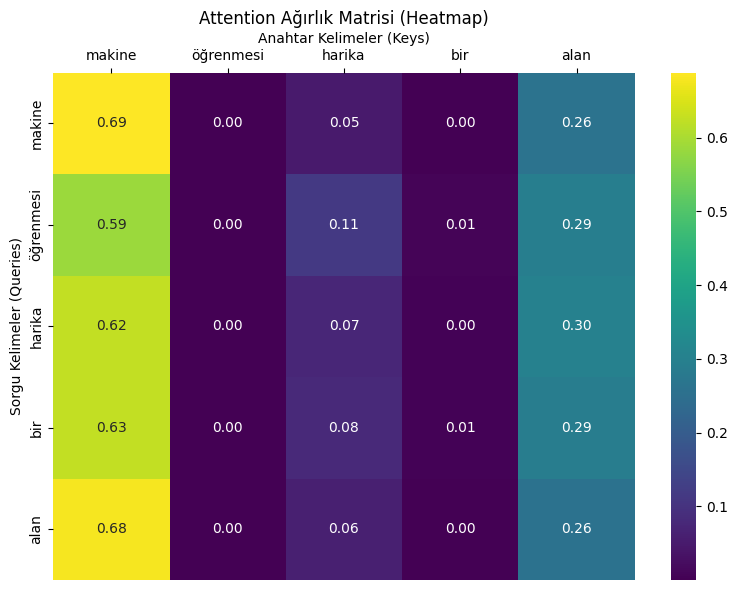

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def softmax(x):
    """Numerik olarak stabil bir softmax fonksiyonu."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def visualize_attention(sentence, attention_matrix):
    """Attention matrisini bir Ä±sÄ± haritasÄ± olarak gÃ¶rselleÅŸtirir."""
    
    # TÃ¼rkÃ§e karakterleri destekleyen bir font bulma denemesi
    try:
        # Ã–rnek olarak yaygÄ±n bir font veya sisteminizde olan bir fontu deneyin
        # Linux iÃ§in: "DejaVu Sans", Windows iÃ§in: "Arial", macOS iÃ§in: "Helvetica Neue"
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=12)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarÄ±: TÃ¼rkÃ§e karakterler iÃ§in 'DejaVu Sans' fontu bulunamadÄ±. Etiketler dÃ¼zgÃ¼n gÃ¶rÃ¼nmeyebilir.")
        print("GÃ¶rselleÅŸtirmeyi iyileÅŸtirmek iÃ§in sisteminizde var olan bir .ttf font dosyasÄ±nÄ±n yolunu koda ekleyebilirsiniz.\n")


    tokens = sentence.split()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=ax)
    
    ax.set_title("Attention AÄŸÄ±rlÄ±k Matrisi (Heatmap)")
    ax.set_xlabel("Anahtar Kelimeler (Keys)")
    ax.set_ylabel("Sorgu Kelimeler (Queries)")
    ax.xaxis.tick_top()  # X ekseni etiketlerini Ã¼ste taÅŸÄ±
    ax.xaxis.set_label_position('top')
    
    plt.tight_layout()
    plt.show()

def attention_step_by_step(sentence):
    """
    Verilen bir cÃ¼mle iÃ§in attention mekanizmasÄ±nÄ± adÄ±m adÄ±m Ã§alÄ±ÅŸtÄ±rÄ±r ve gÃ¶rselleÅŸtirir.
    """
    # makine Ã¶ÄŸrenmesi harika bir alan
    print(f"'{sentence}' cÃ¼mlesi iÃ§in Attention MekanizmasÄ± Analizi")
    print("=" * 60)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. AdÄ±m: Model Parametreleri ve GÃ¶mme VektÃ¶rleri ---
    # EÄŸitim kolaylÄ±ÄŸÄ± iÃ§in boyutlarÄ± kÃ¼Ã§Ã¼k tutuyoruz.
    d_model = 12  # Her kelimenin temsil edildiÄŸi vektÃ¶r boyutu (Embedding boyutu)
    d_k = 4       # Query ve Key vektÃ¶rlerinin boyutu (d_v de aynÄ± olacak)
    
    # Her Ã§alÄ±ÅŸtÄ±rmada aynÄ± sonuÃ§larÄ± almak iÃ§in rastgelelik tohumu
    np.random.seed(42) 
    
    # Her kelime iÃ§in rastgele bir gÃ¶mme vektÃ¶rÃ¼ oluÅŸturalÄ±m.
    # GerÃ§ekte bu vektÃ¶rler bir embedding katmanÄ±ndan gelir.
    embeddings = np.random.rand(vocab_size, d_model)
    
    print(f"1. AdÄ±m: Kelime GÃ¶mme (Word Embeddings) - Boyut: {d_model}")
    for i, token in enumerate(tokens):
        print(f"  '{token}': {np.round(embeddings[i], 2)}")
    print("-" * 60)
        
    # --- 2. AdÄ±m: AÄŸÄ±rlÄ±k Matrisleri ve Q, K, V HesaplanmasÄ± ---
    # Bu matrisler normalde modelin eÄŸitim sÄ±rasÄ±nda Ã¶ÄŸrendiÄŸi aÄŸÄ±rlÄ±klardÄ±r.
    # Biz burada rastgele ama sabit matrisler kullanacaÄŸÄ±z.
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k) # d_v = d_k varsayalÄ±m
    
    # Her kelime iÃ§in Q, K, V vektÃ¶rlerini hesapla
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    print(f"2. AdÄ±m: Q, K, V VektÃ¶rlerinin HesaplanmasÄ± - Boyut: {d_k}")
    print("Ã–rnek olarak ilk kelimenin ('{}') Q, K, V vektÃ¶rleri:".format(tokens[0]))
    print(f"  Q_1: {np.round(Q[0], 2)}")
    print(f"  K_1: {np.round(K[0], 2)}")
    print(f"  V_1: {np.round(V[0], 2)}")
    print("-" * 60)
    
    # --- 3. AdÄ±m: Ham Dikkat SkorlarÄ± ---
    # Her sorgunun (Q) her anahtarla (K) ne kadar iliÅŸkili olduÄŸunu Ã¶lÃ§eriz.
    # FormÃ¼l: scores = Q * K^T
    scores = Q @ K.T
    
    print("3. AdÄ±m: Ham Dikkat SkorlarÄ± (Q @ K.T)")
    print("Her satÄ±r bir 'sorgu' kelimesini, her sÃ¼tun bir 'anahtar' kelimesini temsil eder.")
    print(np.round(scores, 2))
    print("-" * 60)
    
    # --- 4. AdÄ±m: Ã–lÃ§ekleme ---
    # GradyanlarÄ±n Ã§ok kÃ¼Ã§Ã¼lmesini engellemek iÃ§in skorlarÄ± Ã¶lÃ§ekleriz.
    # FormÃ¼l: scores / sqrt(d_k)
    scaled_scores = scores / np.sqrt(d_k)
    
    print(f"4. AdÄ±m: Ã–lÃ§eklenmiÅŸ Skorlar (Skorlar / sqrt({d_k}))")
    print(np.round(scaled_scores, 2))
    print("-" * 60)
    
    # --- 5. AdÄ±m: Softmax ---
    # Ã–lÃ§eklenmiÅŸ skorlarÄ± [0, 1] aralÄ±ÄŸÄ±nda bir olasÄ±lÄ±k daÄŸÄ±lÄ±mÄ±na dÃ¶nÃ¼ÅŸtÃ¼rÃ¼rÃ¼z.
    # Her satÄ±rÄ±n toplamÄ± 1 olur. Bu bizim ATTENTION matrisimizdir.
    attention_weights = softmax(scaled_scores)
    
    print("5. AdÄ±m: Softmax ile AÄŸÄ±rlÄ±klarÄ±n HesaplanmasÄ± (Attention Matrisi)")
    print("Her kelimenin diÄŸer kelimelere ne kadar 'dikkat' edeceÄŸini gÃ¶sterir.")
    print(np.round(attention_weights, 2))
    print("-" * 60)
    
    # --- 6. AdÄ±m: SonuÃ§ VektÃ¶rlerinin HesaplanmasÄ± ---
    # Her kelime iÃ§in nihai Ã§Ä±ktÄ±, dikkat aÄŸÄ±rlÄ±klarÄ± ile DeÄŸer (V) vektÃ¶rlerinin
    # aÄŸÄ±rlÄ±klÄ± toplamÄ±dÄ±r.
    # FormÃ¼l: output = attention_weights * V
    output = attention_weights @ V
    
    print("6. AdÄ±m: Nihai Ã‡Ä±ktÄ± VektÃ¶rleri (Attention_Weights @ V)")
    print("Her kelimenin yeni vektÃ¶rÃ¼, cÃ¼mlenin baÄŸlam bilgisini iÃ§erir.")
    for i, token in enumerate(tokens):
        print(f"  '{token}' iÃ§in yeni vektÃ¶r: {np.round(output[i], 2)}")
    print("-" * 60)
    
    # --- 7. AdÄ±m: GÃ¶rselleÅŸtirme ---
    print("7. AdÄ±m: Attention Matrisinin GÃ¶rselleÅŸtirilmesi")
    visualize_attention(sentence, attention_weights)
    

if __name__ == '__main__':
    # Analiz edilecek Ã¶rnek cÃ¼mle
    ornek_cumle = "makine Ã¶ÄŸrenmesi harika bir alan"
    attention_step_by_step(ornek_cumle)

# 2. Sparse Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri iÅŸlerken zorlanÄ±r' cÃ¼mlesi iÃ§in Full vs. Sparse Attention Analizi
Sparse Attention Pencere Boyutu: 1 (her kelime saÄŸÄ±na ve soluna 1 kelimeye bakar)
1-4. AdÄ±mlar: GÃ¶mme, Q,K,V, Skor ve Ã–lÃ§ekleme iÅŸlemleri her iki yÃ¶ntem iÃ§in de ortaktÄ±r.
Ã–lÃ§eklenmiÅŸ Skor Matrisi:
[[19.   12.66 18.05 14.02 19.24 16.08 15.45]
 [12.83  8.65 12.31  9.56 13.27 10.98 10.42]
 [16.39 11.06 15.57 12.08 16.62 13.87 13.39]
 [15.85 10.61 15.09 11.73 16.12 13.46 12.88]
 [18.89 12.63 17.97 13.92 19.22 15.98 15.39]
 [18.56 12.44 17.67 13.72 18.88 15.74 15.11]
 [15.62 10.41 14.86 11.54 15.86 13.24 12.69]]
--------------------------------------------------------------------------------
a) Full Attention AÄŸÄ±rlÄ±klarÄ± (Softmax uygulanmÄ±ÅŸ hali)
[[0.36 0.   0.14 0.   0.46 0.02 0.01]
 [0.29 0.   0.17 0.01 0.45 0.05 0.03]
 [0.35 0.   0.15 0.   0.44 0.03 0.02]
 [0.34 0.   0.16 0.01 0.45 0.03 0.02]
 [0.35 0.   0.14 0.   0.48 0.02 0.01]
 [0.35 0.   0.14 0.   0.48 0.02 0.

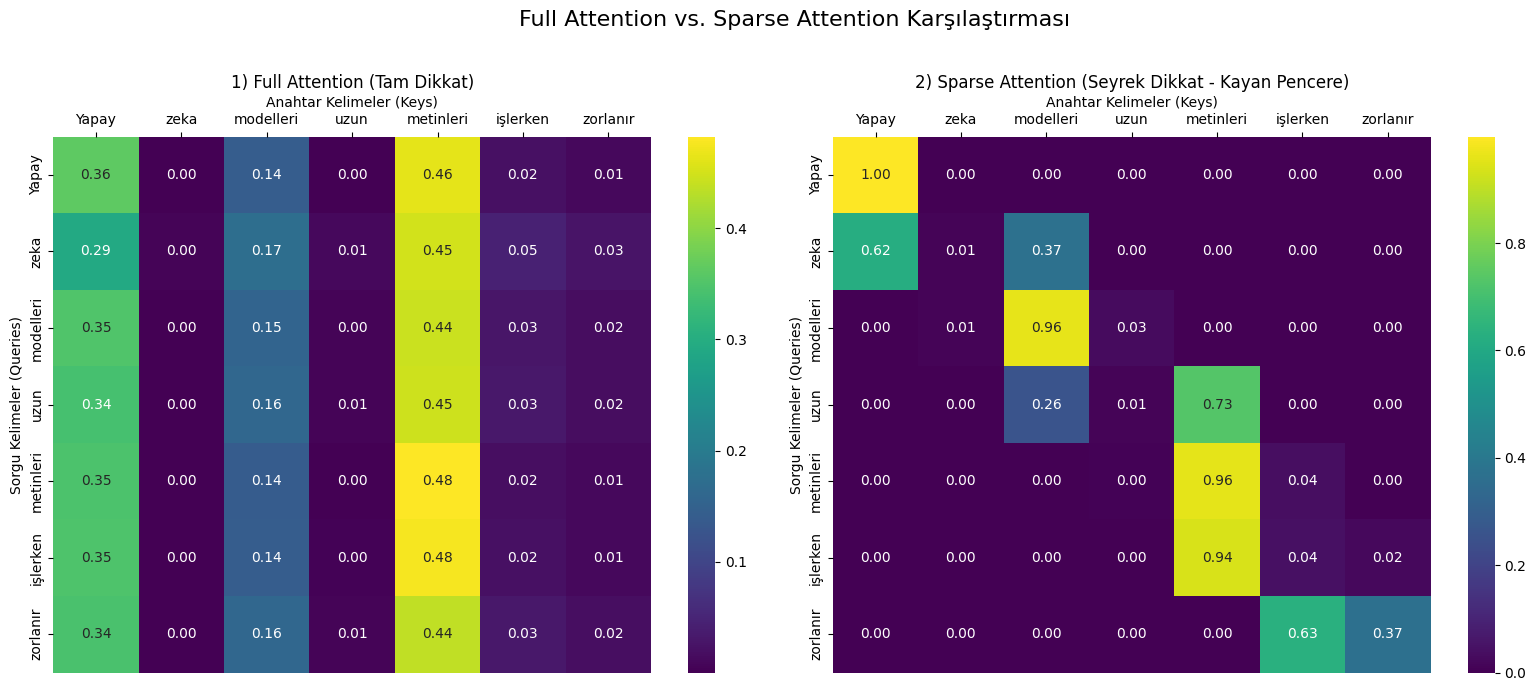

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Bir Ã¶nceki koddan alÄ±nan yardÄ±mcÄ± fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# YENÄ° KARÅžILAÅžTIRMA GÃ–RSELLEÅžTÄ°RME FONKSÄ°YONU
def visualize_attention_comparison(sentence, full_attention_matrix, sparse_attention_matrix):
    """Full ve Sparse Attention matrislerini yan yana gÃ¶rselleÅŸtirir."""
    
    # TÃ¼rkÃ§e karakter desteÄŸi iÃ§in font ayarÄ±
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=10)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarÄ±: 'DejaVu Sans' fontu bulunamadÄ±. GÃ¶rseldeki etiketler dÃ¼zgÃ¼n gÃ¶rÃ¼nmeyebilir.\n")
    
    tokens = sentence.split()
    
    # Ä°ki grafiÄŸi yan yana Ã§izmek iÃ§in bir figure ve subplotlar oluÅŸtur
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Sol Grafik: Full Attention
    sns.heatmap(full_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
    axes[0].set_title("1) Full Attention (Tam Dikkat)")
    axes[0].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[0].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[0].xaxis.tick_top()
    axes[0].xaxis.set_label_position('top')
    
    # SaÄŸ Grafik: Sparse Attention
    sns.heatmap(sparse_attention_matrix, xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f", cmap="viridis", ax=axes[1])
    axes[1].set_title("2) Sparse Attention (Seyrek Dikkat - Kayan Pencere)")
    axes[1].set_xlabel("Anahtar Kelimeler (Keys)")
    axes[1].set_ylabel("Sorgu Kelimeler (Queries)")
    axes[1].xaxis.tick_top()
    axes[1].xaxis.set_label_position('top')
    
    fig.suptitle("Full Attention vs. Sparse Attention KarÅŸÄ±laÅŸtÄ±rmasÄ±", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# YENÄ° MASKE OLUÅžTURMA FONKSÄ°YONU
def create_sliding_window_mask(sequence_length, window_size):
    """
    Kayan pencere (sliding window) sparse attention iÃ§in bir maske oluÅŸturur.
    Pencere dÄ±ÅŸÄ±ndaki pozisyonlara -infinity deÄŸeri atanÄ±r.
    """
    mask = np.zeros((sequence_length, sequence_length))
    for i in range(sequence_length):
        for j in range(sequence_length):
            # EÄŸer j pozisyonu, i'nin penceresi dÄ±ÅŸÄ±ndaysa, maskele
            if abs(i - j) > window_size:
                mask[i, j] = -np.inf
    return mask

def attention_comparison_step_by_step(sentence, window_size=1):
    """
    Full ve Sparse Attention mekanizmalarÄ±nÄ± karÅŸÄ±laÅŸtÄ±rÄ±r.
    """
    print(f"'{sentence}' cÃ¼mlesi iÃ§in Full vs. Sparse Attention Analizi")
    print(f"Sparse Attention Pencere Boyutu: {window_size} (her kelime saÄŸÄ±na ve soluna {window_size} kelimeye bakar)")
    print("=" * 80)

    tokens = sentence.split()
    vocab_size = len(tokens)
    
    # --- 1. ve 2. AdÄ±mlar (Ortak) ---
    d_model = 12
    d_k = 4
    np.random.seed(42) 
    
    embeddings = np.random.rand(vocab_size, d_model)
    W_q = np.random.rand(d_model, d_k)
    W_k = np.random.rand(d_model, d_k)
    W_v = np.random.rand(d_model, d_k)
    
    Q = embeddings @ W_q
    K = embeddings @ W_k
    V = embeddings @ W_v
    
    # --- 3. ve 4. AdÄ±mlar (Ortak) ---
    scores = Q @ K.T
    scaled_scores = scores / np.sqrt(d_k)
    
    print("1-4. AdÄ±mlar: GÃ¶mme, Q,K,V, Skor ve Ã–lÃ§ekleme iÅŸlemleri her iki yÃ¶ntem iÃ§in de ortaktÄ±r.")
    print("Ã–lÃ§eklenmiÅŸ Skor Matrisi:")
    print(np.round(scaled_scores, 2))
    print("-" * 80)
    
    # --- FULL ATTENTION HESAPLAMASI ---
    full_attention_weights = softmax(scaled_scores)
    print("a) Full Attention AÄŸÄ±rlÄ±klarÄ± (Softmax uygulanmÄ±ÅŸ hali)")
    print(np.round(full_attention_weights, 2))
    print("-" * 80)

    # --- SPARSE ATTENTION HESAPLAMASI ---
    
    # 5. AdÄ±m: Seyreltme Maskesi OluÅŸturma (YENÄ° ADIM)
    print("b) Sparse Attention iÃ§in adÄ±mlar:")
    print("5. AdÄ±m: Kayan Pencere Maskesi OluÅŸturma")
    print("Pencere dÄ±ÅŸÄ±ndaki konumlara -inf deÄŸeri atanÄ±r, bÃ¶ylece softmax sonrasÄ± skorlarÄ± 0 olur.")
    mask = create_sliding_window_mask(vocab_size, window_size)
    print(mask)
    print("-" * 80)
    
    # 6. AdÄ±m: Maskeyi Uygulama (YENÄ° ADIM)
    print("6. AdÄ±m: Maskenin Ã–lÃ§eklenmiÅŸ Skorlara UygulanmasÄ±")
    masked_scores = scaled_scores + mask
    print("Maske uygulandÄ±ktan sonraki skorlar (softmax Ã¶ncesi):")
    print(np.round(masked_scores, 2))
    print("-" * 80)
    
    # 7. AdÄ±m: Maskeli Skorlara Softmax Uygulama
    sparse_attention_weights = softmax(masked_scores)
    print("7. AdÄ±m: Sparse Attention AÄŸÄ±rlÄ±klarÄ± (Maskeli skorlara Softmax uygulanmÄ±ÅŸ hali)")
    print("Dikkat'in sadece komÅŸu kelimelere odaklandÄ±ÄŸÄ±na dikkat edin.")
    print(np.round(sparse_attention_weights, 2))
    print("-" * 80)
    
    # --- 8. AdÄ±m: KarÅŸÄ±laÅŸtÄ±rmalÄ± GÃ¶rselleÅŸtirme ---
    print("8. AdÄ±m: SonuÃ§larÄ±n KarÅŸÄ±laÅŸtÄ±rÄ±lmasÄ±")
    print("Ä°ki dikkat matrisi ÅŸimdi gÃ¶rselleÅŸtirilecek...")
    visualize_attention_comparison(sentence, full_attention_weights, sparse_attention_weights)

if __name__ == '__main__':
    # Sparse attention etkisini daha iyi gÃ¶rmek iÃ§in biraz daha uzun bir cÃ¼mle
    ornek_cumle = "Yapay zeka modelleri uzun metinleri iÅŸlerken zorlanÄ±r"
    
    # Pencere boyutu: Her kelime, saÄŸÄ±ndaki ve solundaki 1 kelimeye dikkat eder.
    # Bu deÄŸeri 2 veya 3 yaparak pencereyi geniÅŸletebilirsiniz.
    pencere_boyutu = 1
    
    attention_comparison_step_by_step(ornek_cumle, window_size=pencere_boyutu)

# 3. Big Birds Attention (Dikkat)

'Yapay zeka modelleri uzun metinleri iÅŸlerken hesaplama maliyeti nedeniyle zorlanÄ±r' cÃ¼mlesi iÃ§in Attention MekanizmalarÄ± Analizi
BigBird Parametreleri -> Pencere: 2, Rastgele: 2, Genel: [0]
BigBird Maskesi OluÅŸturuluyor...
Analiz tamamlandÄ±. KarÅŸÄ±laÅŸtÄ±rma grafiÄŸi oluÅŸturuluyor...

UyarÄ±: 'DejaVu Sans' fontu bulunamadÄ±. GÃ¶rseldeki etiketler dÃ¼zgÃ¼n gÃ¶rÃ¼nmeyebilir.



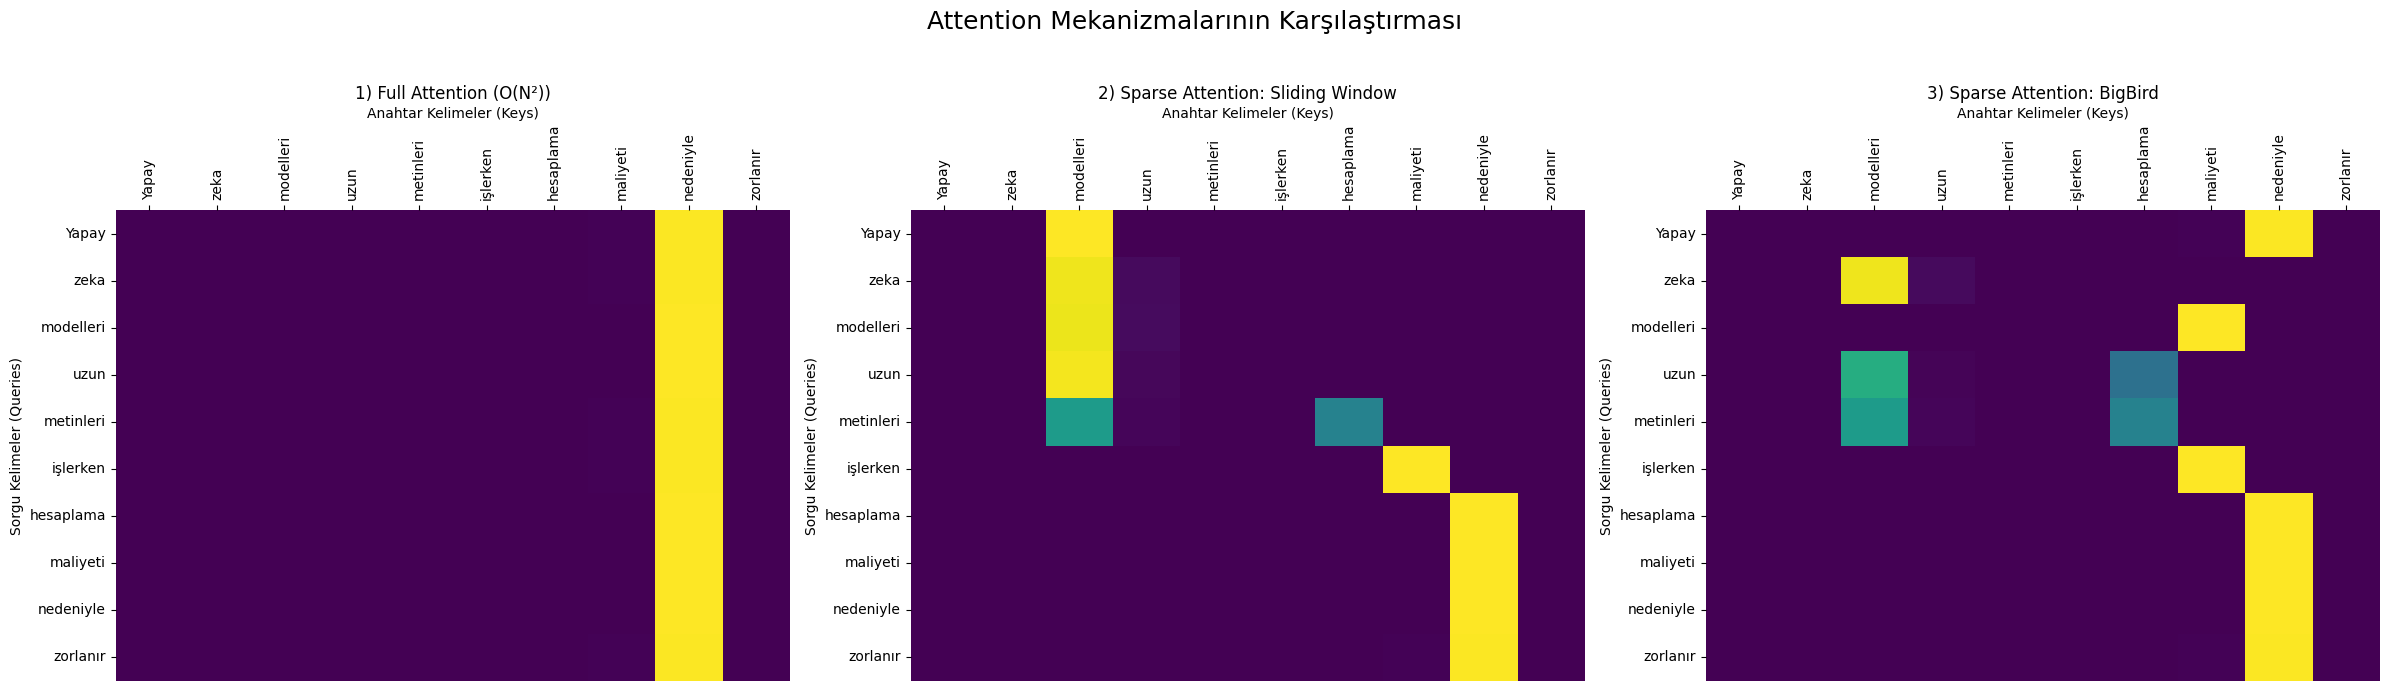

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- Ã–nceki kodlardan alÄ±nan yardÄ±mcÄ± fonksiyonlar ---
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# --- BigBird iÃ§in yeni maske oluÅŸturma fonksiyonlarÄ± ---

def create_sliding_window_mask(sequence_length, window_size):
    """Kayan pencere iÃ§in maske oluÅŸturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        start = max(0, i - window_size)
        end = min(sequence_length, i + window_size + 1)
        mask[i, start:end] = 0
    return mask

def create_random_mask(sequence_length, num_random_tokens, window_size):
    """Rastgele dikkat iÃ§in maske oluÅŸturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    for i in range(sequence_length):
        # Rastgele indisleri seÃ§
        random_indices = np.random.choice(sequence_length, num_random_tokens, replace=False)
        mask[i, random_indices] = 0
    return mask

def create_global_mask(sequence_length, global_indices):
    """Genel dikkat iÃ§in maske oluÅŸturur."""
    mask = np.full((sequence_length, sequence_length), -np.inf)
    # Global token'larÄ±n olduÄŸu satÄ±r ve sÃ¼tunlarÄ± tamamen aÃ§
    mask[global_indices, :] = 0
    mask[:, global_indices] = 0
    return mask

# --- YENÄ° 3'LÃœ KARÅžILAÅžTIRMA GÃ–RSELLEÅžTÄ°RME FONKSÄ°YONU ---
def visualize_bigbird_comparison(sentence, full_att, window_att, bigbird_att):
    """ÃœÃ§ dikkat matrisini yan yana gÃ¶rselleÅŸtirir."""
    try:
        font_prop = fm.FontProperties(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', size=9)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("\nUyarÄ±: 'DejaVu Sans' fontu bulunamadÄ±. GÃ¶rseldeki etiketler dÃ¼zgÃ¼n gÃ¶rÃ¼nmeyebilir.\n")
    
    tokens = sentence.split()
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Grafik 1: Full Attention
    sns.heatmap(full_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[0], cbar=False)
    axes[0].set_title("1) Full Attention (O(NÂ²))")
    
    # Grafik 2: Sliding Window Attention
    sns.heatmap(window_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[1], cbar=False)
    axes[1].set_title("2) Sparse Attention: Sliding Window")

    # Grafik 3: BigBird Attention
    sns.heatmap(bigbird_att, xticklabels=tokens, yticklabels=tokens, annot=False, cmap="viridis", ax=axes[2], cbar=False)
    axes[2].set_title("3) Sparse Attention: BigBird")

    for ax in axes:
        ax.set_xlabel("Anahtar Kelimeler (Keys)")
        ax.set_ylabel("Sorgu Kelimeler (Queries)")
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.setp(ax.get_xticklabels(), rotation=90)


    fig.suptitle("Attention MekanizmalarÄ±nÄ±n KarÅŸÄ±laÅŸtÄ±rmasÄ±", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def bigbird_attention_demo(sentence, window_size=1, num_random_tokens=1, global_indices=[0]):
    """
    Full, Sliding Window ve BigBird Attention mekanizmalarÄ±nÄ± karÅŸÄ±laÅŸtÄ±rÄ±r.
    """
    print(f"'{sentence}' cÃ¼mlesi iÃ§in Attention MekanizmalarÄ± Analizi")
    print(f"BigBird Parametreleri -> Pencere: {window_size}, Rastgele: {num_random_tokens}, Genel: {global_indices}")
    print("=" * 80)
    
    tokens = sentence.split()
    seq_len = len(tokens)
    
    # AdÄ±m 1-4: Ortak Hesaplamalar
    d_model, d_k = 32, 8
    np.random.seed(42)
    embeddings = np.random.rand(seq_len, d_model)
    W_q, W_k, W_v = [np.random.rand(d_model, d_k) for _ in range(3)]
    Q, K, V = embeddings @ W_q, embeddings @ W_k, embeddings @ W_v
    scaled_scores = (Q @ K.T) / np.sqrt(d_k)
    
    # 1. YOL: FULL ATTENTION
    full_attention_weights = softmax(scaled_scores)
    
    # 2. YOL: SLIDING WINDOW ATTENTION
    window_mask = create_sliding_window_mask(seq_len, window_size)
    window_attention_weights = softmax(scaled_scores + window_mask)
    
    # 3. YOL: BIGBIRD ATTENTION
    print("BigBird Maskesi OluÅŸturuluyor...")
    # ÃœÃ§ farklÄ± maskeyi oluÅŸtur
    mask1_window = create_sliding_window_mask(seq_len, window_size)
    mask2_random = create_random_mask(seq_len, num_random_tokens, window_size)
    mask3_global = create_global_mask(seq_len, global_indices)
    
    # Maskeleri birleÅŸtir. Bir pozisyona herhangi bir maske izin veriyorsa (0 ise),
    # o pozisyon aÃ§Ä±k kalmalÄ±dÄ±r.
    bigbird_mask = np.maximum.reduce([mask1_window, mask2_random, mask3_global])
    
    # BigBird aÄŸÄ±rlÄ±klarÄ±nÄ± hesapla
    bigbird_attention_weights = softmax(scaled_scores + bigbird_mask)
    
    print("Analiz tamamlandÄ±. KarÅŸÄ±laÅŸtÄ±rma grafiÄŸi oluÅŸturuluyor...")
    
    # SonuÃ§larÄ± gÃ¶rselleÅŸtir
    visualize_bigbird_comparison(sentence, full_attention_weights, window_attention_weights, bigbird_attention_weights)


if __name__ == '__main__':
    ornek_cumle = "Yapay zeka modelleri uzun metinleri iÅŸlerken hesaplama maliyeti nedeniyle zorlanÄ±r"
    
    # BigBird Parametreleri
    pencere_boyutu = 2       # Her kelime saÄŸÄ±na/soluna 2 kelimeye bakar
    rastgele_token_sayisi = 2 # Her kelime rastgele 2 kelimeye daha bakar
    genel_token_indisleri = [0] # Ä°lk kelime ('Yapay') genel token'dÄ±r
    
    bigbird_attention_demo(ornek_cumle, pencere_boyutu, rastgele_token_sayisi, genel_token_indisleri)

# 4. Flash Attention

In [6]:
import numpy as np

def naive_attention(Q, K, V):
    """Standart, basit ve verimsiz attention hesaplamasÄ±."""
    print("--- 1) Naif (Standart) Attention HesaplanÄ±yor ---")
    d_k = Q.shape[-1]
    
    # TÃ¼m matrisler Ã¼zerinde tek seferde iÅŸlem yapÄ±lÄ±r
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights /= np.sum(weights, axis=-1, keepdims=True)
    output = weights @ V
    
    print("Naif Attention tamamlandÄ±. SonuÃ§ hafÄ±zada.\n")
    return output

def flash_attention_detailed_steps(Q, K, V, block_size):
    """
    FlashAttention'Ä±n mantÄ±ÄŸÄ±nÄ±, ara adÄ±mlarÄ± detaylÄ± bir ÅŸekilde basarak simÃ¼le eder.
    BU BÄ°R PERFORMANS OPTÄ°MÄ°ZASYONU DEÄžÄ°L, KAVRAMSAL BÄ°R SÄ°MÃœLASYONDUR.
    """
    print(f"--- 2) FlashAttention (DetaylÄ± AdÄ±mlar) HesaplanÄ±yor (Blok Boyutu: {block_size}) ---")
    
    seq_len, d_k = Q.shape
    output = np.zeros_like(Q)
    
    num_blocks = seq_len // block_size
    
    # Sadece ilk satÄ±rÄ±n (ilk kelimenin) evrimini takip edeceÄŸiz
    trace_row_index = 0

    # Q matrisini bloklara ayÄ±r (DÄ±ÅŸ DÃ¶ngÃ¼)
    for i in range(num_blocks):
        start_i, end_i = i * block_size, (i + 1) * block_size
        Q_block = Q[start_i:end_i, :]
        
        # Bu Q bloÄŸu iÃ§in Ã§Ä±ktÄ± ve istatistikleri baÅŸlat
        O_block = np.zeros_like(Q_block)
        l_block = np.zeros(block_size)
        m_block = np.full(block_size, -np.inf)
        
        print(f"\n[DÄ±ÅŸ DÃ¶ngÃ¼] Q'nun {i+1}. bloÄŸu iÅŸleniyor (SatÄ±r {start_i}-{end_i-1})...")
        if start_i <= trace_row_index < end_i:
            print(f"  Takip edilen satÄ±r ({trace_row_index}) iÃ§in baÅŸlangÄ±Ã§ durumu:")
            print(f"    m (max skor) = {m_block[trace_row_index - start_i]:.2f}, l (norm. faktÃ¶r) = {l_block[trace_row_index - start_i]:.2f}")
            print(f"    O (Ã§Ä±ktÄ±)    = {np.round(O_block[trace_row_index - start_i], 2)}")

        # K ve V matrislerini bloklara ayÄ±r (Ä°Ã§ DÃ¶ngÃ¼)
        for j in range(num_blocks):
            start_j, end_j = j * block_size, (j + 1) * block_size
            K_block = K[start_j:end_j, :]
            V_block = V[start_j:end_j, :]
            
            # --- SRAM Ä°Ã‡Ä°NDEKÄ° HESAPLAMALAR ---
            S_ij = (Q_block @ K_block.T) / np.sqrt(d_k)
            
            # Online Softmax gÃ¼ncellemesi
            m_old = m_block
            l_old = l_block
            O_old = np.copy(O_block) # KarÅŸÄ±laÅŸtÄ±rma iÃ§in kopyala
            
            m_new = np.maximum(m_old, np.max(S_ij, axis=1))
            P_ij = np.exp(S_ij - m_new[:, np.newaxis])
            exp_m_diff = np.exp(m_old - m_new)
            
            l_new = exp_m_diff * l_old + np.sum(P_ij, axis=1)
            
            # O vektÃ¶rÃ¼nÃ¼ gÃ¼ncelle: Eski deÄŸeri yeniden Ã¶lÃ§eklendir ve yeni deÄŸeri ekle
            O_block = O_old * exp_m_diff[:, np.newaxis]
            O_block += (P_ij @ V_block)
            
            # Bir sonraki dÃ¶ngÃ¼ iÃ§in m ve l'yi gÃ¼ncelle
            m_block = m_new
            l_block = l_new
            
            if start_i <= trace_row_index < end_i:
                print(f"  [Ä°Ã§ DÃ¶ngÃ¼] K/V'nin {j+1}. bloÄŸu iÅŸlendi:")
                print(f"    m gÃ¼ncellendi: {m_old[trace_row_index - start_i]:.2f} -> {m_new[trace_row_index - start_i]:.2f}")
                print(f"    l gÃ¼ncellendi: {l_old[trace_row_index - start_i]:.2f} -> {l_new[trace_row_index - start_i]:.2f}")
                print(f"    O gÃ¼ncellendi: {np.round(O_old[trace_row_index - start_i, :4], 2)} -> {np.round(O_block[trace_row_index - start_i, :4], 2)}")

        # Bu Q bloÄŸu iÃ§in tÃ¼m hesaplamalar bitti, nihai sonucu HBM'e yaz
        output[start_i:end_i, :] = O_block / l_block[:, np.newaxis]

    print("\nTÃ¼m bloklar iÅŸlendi. FlashAttention tamamlandÄ±.\n")
    return output

if __name__ == '__main__':
    # Parametreler
    SEQUENCE_LENGTH = 128 
    D_MODEL = 64
    BLOCK_SIZE = 32 

    # Rastgele Q, K, V matrisleri oluÅŸtur
    np.random.seed(42)
    Q = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    K = np.random.randn(SEQUENCE_LENGTH, D_MODEL)
    V = np.random.randn(SEQUENCE_LENGTH, D_MODEL)

    # 1. YÃ¶ntem: Standart YaklaÅŸÄ±m (Referans sonuÃ§)
    output_naive = naive_attention(Q, K, V)
    
    # 2. YÃ¶ntem: FlashAttention AdÄ±m AdÄ±m SimÃ¼lasyonu
    output_flash = flash_attention_detailed_steps(Q, K, V, BLOCK_SIZE)
    
    # 3. SonuÃ§larÄ± KarÅŸÄ±laÅŸtÄ±rma
    print("--- 3) SonuÃ§larÄ±n KarÅŸÄ±laÅŸtÄ±rÄ±lmasÄ± ---")
    are_same = np.allclose(output_naive, output_flash, atol=1e-6)
    
    print(f"Naif Attention ve FlashAttention sonuÃ§larÄ± matematiksel olarak aynÄ± mÄ±? -> {are_same}")
    if are_same:
        print("KanÄ±t: AdÄ±m adÄ±m ilerleyen 'online' gÃ¼ncelleme mekanizmasÄ±, tek seferde yapÄ±lan hesaplama ile aynÄ± sonucu vermiÅŸtir.")
    else:
        print("Hata: SonuÃ§lar farklÄ±, simÃ¼lasyonda bir sorun var.")

    print("\nNihai Ã‡Ä±ktÄ± KarÅŸÄ±laÅŸtÄ±rmasÄ± (ilk satÄ±r):")
    print("Naif  :", np.round(output_naive[0, :5], 4))
    print("Flash :", np.round(output_flash[0, :5], 4))

--- 1) Naif (Standart) Attention HesaplanÄ±yor ---
Naif Attention tamamlandÄ±. SonuÃ§ hafÄ±zada.

--- 2) FlashAttention (DetaylÄ± AdÄ±mlar) HesaplanÄ±yor (Blok Boyutu: 32) ---

[DÄ±ÅŸ DÃ¶ngÃ¼] Q'nun 1. bloÄŸu iÅŸleniyor (SatÄ±r 0-31)...
  Takip edilen satÄ±r (0) iÃ§in baÅŸlangÄ±Ã§ durumu:
    m (max skor) = -inf, l (norm. faktÃ¶r) = 0.00
    O (Ã§Ä±ktÄ±)    = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [Ä°Ã§ DÃ¶ngÃ¼] K/V'nin 1. bloÄŸu iÅŸlendi:
    m gÃ¼ncellendi: -inf -> 1.69
    l gÃ¼ncellendi: 0.00 -> 7.83
    O gÃ¼ncellendi: [0. 0. 0. 0.] -> [-4.61  2.12  0.68 -0.24]
  [Ä°Ã§ DÃ¶ngÃ¼] K/V'nin 2. bloÄŸu iÅŸlendi:
    m gÃ¼ncellendi: 1.69 -> 1.69
    l gÃ¼ncellendi: 7.83 -> 15.34
    O gÃ¼ncellendi: [-4.61  2.12  0.68 -0.24] -> [-2.96  3.25 -1.54 -1.71]
  [Ä°Ã§ DÃ¶ngÃ¼] K/V'nin 3. bloÄŸu iÅŸlendi:
    m gÃ¼ncellendi: 1.69 -> 2.01
   

# Multi Head Attention

In [7]:
import torch
import torch.nn.functional as F
import numpy as np

def single_head_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

def multi_head_attention(Q, K, V, num_heads):
    batch_size, seq_len, d_model = Q.size()
    assert d_model % num_heads == 0, "d_model num_heads'e tam bÃ¶lÃ¼nmelidir"
    d_k = d_model // num_heads

    # Lineer projeksiyonlar (baÅŸlÄ±k sayÄ±sÄ± kadar)
    Q = Q.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)  # (B, h, S, d_k)
    K = K.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)
    V = V.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)

    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    print("Her head iÃ§in attention score matrisleri:")
    for i, head_weights in enumerate(weights[0]):
        print(f"\nHead {i+1}:")
        print(np.round(head_weights.detach().numpy(), 2))

    attended = torch.matmul(weights, V)  # (B, h, S, d_k)
    concat = attended.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
    return concat, weights

# SimÃ¼lasyon: 1 Ã¶rnek, 4 kelime, 8 boyutlu embedding
torch.manual_seed(42)
x = torch.randn(1, 4, 8)  # (batch, seq_len, d_model)

# Tek baÅŸlÄ± attention
Q = K = V = x.clone()
output_single, weights_single = single_head_attention(Q[0], K[0], V[0])
print("\n--- Tek BaÅŸlÄ± Attention ---")
print("Attention Ã§Ä±ktÄ±sÄ±:", np.round(output_single.detach().numpy(), 2))

# Ã‡ok baÅŸlÄ± attention (2 head)
print("\n--- Multi-Head Attention (2 Head) ---")
output_multi, weights_multi = multi_head_attention(Q, K, V, num_heads=2)
print("MHA Ã‡Ä±ktÄ±sÄ±:", np.round(output_multi[0].detach().numpy(), 2))



--- Tek BaÅŸlÄ± Attention ---
Attention Ã§Ä±ktÄ±sÄ±: [[ 1.9   1.49  0.89 -2.08  0.66 -1.22 -0.05 -1.57]
 [-0.18  1.54 -0.16 -1.28 -0.5  -0.56 -0.58  0.47]
 [ 1.53  0.13 -0.31  0.49 -0.66  0.84  0.59  1.48]
 [ 1.28  0.99  0.3   0.66 -0.32  0.15 -0.02  0.85]]

--- Multi-Head Attention (2 Head) ---
Her head iÃ§in attention score matrisleri:

Head 1:
[[0.96 0.02 0.01 0.01]
 [0.28 0.68 0.02 0.03]
 [0.21 0.04 0.47 0.29]
 [0.13 0.03 0.14 0.7 ]]

Head 2:
[[0.89 0.06 0.01 0.04]
 [0.1  0.43 0.21 0.26]
 [0.01 0.08 0.79 0.12]
 [0.08 0.29 0.36 0.27]]
MHA Ã‡Ä±ktÄ±sÄ±: [[ 1.86  1.48  0.86 -2.03  0.55 -1.12 -0.08 -1.34]
 [ 0.09  1.56 -0.01 -1.49 -0.47 -0.12 -0.23  0.76]
 [ 1.51  0.67  0.12  0.09 -0.68  0.81  0.54  1.49]
 [ 1.36  1.13  0.47  0.68 -0.49  0.14 -0.    0.93]]


In [8]:
import torch
import torch.nn.functional as F
import numpy as np

# Tek baÅŸlÄ± attention
def single_head_attention(Q, K, V):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.T) / np.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

# Ã‡ok baÅŸlÄ± attention
def multi_head_attention(Q, K, V, num_heads=2):
    d_model = Q.shape[-1]
    assert d_model % num_heads == 0
    d_k = d_model // num_heads

    # Split and stack Q, K, V
    Q_heads = Q.reshape(Q.shape[0], num_heads, d_k)
    K_heads = K.reshape(K.shape[0], num_heads, d_k)
    V_heads = V.reshape(V.shape[0], num_heads, d_k)

    weights_all = []
    head_outputs = []
    for h in range(num_heads):
        Qh, Kh, Vh = Q_heads[:, h], K_heads[:, h], V_heads[:, h]
        scores = torch.matmul(Qh, Kh.T) / np.sqrt(d_k)
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, Vh)
        weights_all.append(weights.unsqueeze(1))
        head_outputs.append(output)
    
    # Concatenate head outputs
    final_output = torch.cat(head_outputs, dim=-1)
    all_weights = torch.cat(weights_all, dim=1)
    return final_output, all_weights

# Soru ve baÄŸlam
tokens = ["tÃ¼rkiye", "baÅŸkenti", "ankara", "baÅŸkent", "neresidir"]
context = ["tÃ¼rkiye", "baÅŸkenti", "ankara"]
question = ["baÅŸkent", "neresidir"]

# SÃ¶zlÃ¼k ve embedding
token_to_idx = {tok: i for i, tok in enumerate(tokens)}
torch.manual_seed(0)
embedding = torch.randn(len(tokens), 4)  # 4 boyutlu vektÃ¶r, 2 head iÃ§in

context_embed = embedding[[token_to_idx[t] for t in context]]
question_embed = embedding[[token_to_idx[t] for t in question]]

print("\n Soru:", question)
print("BaÄŸlam:", context)

# Tek baÅŸlÄ± attention
Q = question_embed
K = V = context_embed
single_out, single_weights = single_head_attention(Q, K, V)
print("\nðŸ”¹ Tek BaÅŸlÄ± Attention AÄŸÄ±rlÄ±klarÄ±:")
print(np.round(single_weights.detach().numpy(), 2))

# Ã‡ok baÅŸlÄ± attention
multi_out, multi_weights = multi_head_attention(Q, K, V, num_heads=2)
print("\n Ã‡ok BaÅŸlÄ± Attention Head 1:")
print(np.round(multi_weights[:, 0, :].detach().numpy(), 2))
print("\n Ã‡ok BaÅŸlÄ± Attention Head 2:")
print(np.round(multi_weights[:, 1, :].detach().numpy(), 2))



 Soru: ['baÅŸkent', 'neresidir']
BaÄŸlam: ['tÃ¼rkiye', 'baÅŸkenti', 'ankara']

ðŸ”¹ Tek BaÅŸlÄ± Attention AÄŸÄ±rlÄ±klarÄ±:
[[0.08 0.07 0.85]
 [0.04 0.07 0.89]]

 Ã‡ok BaÅŸlÄ± Attention Head 1:
[[0.05 0.18 0.77]
 [0.1  0.22 0.69]]

 Ã‡ok BaÅŸlÄ± Attention Head 2:
[[0.3  0.07 0.62]
 [0.08 0.07 0.85]]


# 5. Mixture of Experts (MoE) Uzmanlar KarmasÄ±

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. AdÄ±m: Uzman (Expert) ModÃ¼lÃ¼nÃ¼ TanÄ±mlama
# Her bir uzman, basit bir Feed-Forward Network (FFN) olacak.
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Basit bir iki katmanlÄ± aÄŸ: Linear -> ReLU -> Linear
        hidden = F.relu(self.fc1(x))
        output = self.fc2(hidden)
        return output

# 2. AdÄ±m: YÃ¶nlendirici (Gating Network) ModÃ¼lÃ¼nÃ¼ TanÄ±mlama
# Bu aÄŸ, hangi uzmanÄ±n hangi token iÃ§in ne kadar uygun olduÄŸuna karar verir.
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        # Ã‡Ä±ktÄ±sÄ±, uzman sayÄ±sÄ± kadar olan basit bir lineer katman
        self.layer = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Girdiyi alÄ±r ve her uzman iÃ§in bir "puan" (logit) Ã¼retir.
        logits = self.layer(x)
        return logits

# 3. AdÄ±m: MoE KatmanÄ±nÄ± Bir Araya Getirme
class MoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k

        # UzmanlarÄ± bir liste iÃ§inde oluÅŸtur
        # nn.ModuleList, PyTorch'un bu uzmanlarÄ± modelin bir parÃ§asÄ± olarak gÃ¶rmesini saÄŸlar.
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])
        
        # YÃ¶nlendirici aÄŸÄ± oluÅŸtur
        self.gating_network = GatingNetwork(input_dim, num_experts)
        print(f"{num_experts} uzmanlÄ± ve top_k={top_k} olacak ÅŸekilde bir MoE katmanÄ± oluÅŸturuldu.")

    def forward(self, x):
        # x'in ÅŸekli: (batch_size, sequence_len, input_dim)
        # EÄŸitim kolaylÄ±ÄŸÄ± iÃ§in batch_size=1 ve sequence_len=token sayÄ±sÄ± varsayalÄ±m.
        # x'in ÅŸekli: (num_tokens, input_dim)
        num_tokens, input_dim = x.shape

        # AdÄ±m A: YÃ¶nlendiriciden her token iÃ§in uzman puanlarÄ±nÄ± al
        # gating_logits ÅŸekli: (num_tokens, num_experts)
        gating_logits = self.gating_network(x)
        
        # AdÄ±m B: Her token iÃ§in en iyi k uzmanÄ± ve onlarÄ±n puanlarÄ±nÄ± seÃ§
        # torch.topk, hem deÄŸerleri (puanlarÄ±) hem de indisleri dÃ¶ndÃ¼rÃ¼r.
        top_k_logits, top_k_indices = torch.topk(gating_logits, self.top_k, dim=-1)
        
        # AdÄ±m C: SeÃ§ilen k uzmanÄ±n puanlarÄ±na softmax uygulayarak aÄŸÄ±rlÄ±klar elde et
        # Bu aÄŸÄ±rlÄ±klarÄ±n toplamÄ± her token iÃ§in 1 olur.
        top_k_weights = F.softmax(top_k_logits, dim=-1)

        # AdÄ±m D: Ã‡Ä±ktÄ±yÄ± hesapla
        final_output = torch.zeros_like(x)

        # Her bir token iÃ§in adÄ±m adÄ±m iÅŸlem yapalÄ±m (anlaÅŸÄ±lÄ±rlÄ±k iÃ§in dÃ¶ngÃ¼ kullanÄ±yoruz)
        print("\n--- Token BazÄ±nda Uzman SeÃ§imi ve Hesaplama ---")
        for i in range(num_tokens):
            print(f"\nToken {i+1} iÃ§in analiz:")
            print(f"  TÃ¼m uzmanlar iÃ§in ham puanlar (logits): {np.round(gating_logits[i].detach().numpy(), 2)}")
            print(f"  SeÃ§ilen en iyi {self.top_k} uzman (indisler): {top_k_indices[i].tolist()}")
            print(f"  Bu uzmanlarÄ±n aÄŸÄ±rlÄ±klarÄ± (softmax sonrasÄ±): {np.round(top_k_weights[i].detach().numpy(), 2)}")

            token_output = torch.zeros(input_dim)
            
            # SeÃ§ilen k uzmanÄ± dÃ¶ngÃ¼ye al
            for j in range(self.top_k):
                expert_index = top_k_indices[i, j].item()
                expert_weight = top_k_weights[i, j]
                
                # Ä°lgili uzmandan Ã§Ä±ktÄ±yÄ± al
                expert_output = self.experts[expert_index](x[i])
                
                # AÄŸÄ±rlÄ±klÄ± Ã§Ä±ktÄ±yÄ± topla
                token_output += expert_weight * expert_output

                print(f"    -> Uzman {expert_index} Ã§alÄ±ÅŸtÄ±. AÄŸÄ±rlÄ±k: {expert_weight:.2f}")

            final_output[i] = token_output
        
        return final_output

if __name__ == '__main__':
    # SimÃ¼lasyon iÃ§in parametreler
    # Genellikle bir cÃ¼mlenin embedding vektÃ¶rlerinin boyutu
    input_dim = 32    
    # Her uzmanÄ±n iÃ§indeki gizli katman boyutu
    hidden_dim = 64   
    # Ã‡Ä±ktÄ± boyutu (girdi ile aynÄ±)
    output_dim = 32   
    # Toplam uzman sayÄ±sÄ±
    num_experts = 8   
    # Her token iÃ§in seÃ§ilecek en iyi uzman sayÄ±sÄ±
    top_k = 2         

    # Modeli oluÅŸtur
    moe_layer = MoELayer(input_dim, hidden_dim, output_dim, num_experts, top_k)

    # 4 farklÄ± token'dan oluÅŸan sahte bir girdi oluÅŸturalÄ±m
    # (Ã–rn: "Yapay zeka harikadÄ±r" cÃ¼mlesinin token vektÃ¶rleri)
    num_tokens = 4
    input_tokens = torch.randn(num_tokens, input_dim)

    # Modeli Ã§alÄ±ÅŸtÄ±r ve Ã§Ä±ktÄ±yÄ± al
    final_output = moe_layer(input_tokens)

    print("\n--- Nihai SonuÃ§ ---")
    print(f"MoE katmanÄ±ndan geÃ§en {num_tokens} token'Ä±n nihai Ã§Ä±ktÄ± vektÃ¶rleri:")
    # Ã‡Ä±ktÄ±nÄ±n sadece ilk 5 boyutunu gÃ¶sterelim
    print(np.round(final_output[:, :5].detach().numpy(), 3))

8 uzmanlÄ± ve top_k=2 olacak ÅŸekilde bir MoE katmanÄ± oluÅŸturuldu.

--- Token BazÄ±nda Uzman SeÃ§imi ve Hesaplama ---

Token 1 iÃ§in analiz:
  TÃ¼m uzmanlar iÃ§in ham puanlar (logits): [-1.38  0.43 -0.45  0.92  0.08 -1.07  0.12 -0.12]
  SeÃ§ilen en iyi 2 uzman (indisler): [3, 1]
  Bu uzmanlarÄ±n aÄŸÄ±rlÄ±klarÄ± (softmax sonrasÄ±): [0.62 0.38]
    -> Uzman 3 Ã§alÄ±ÅŸtÄ±. AÄŸÄ±rlÄ±k: 0.62
    -> Uzman 1 Ã§alÄ±ÅŸtÄ±. AÄŸÄ±rlÄ±k: 0.38

Token 2 iÃ§in analiz:
  TÃ¼m uzmanlar iÃ§in ham puanlar (logits): [-0.78 -0.2   1.39  0.27  0.25 -1.05 -0.46  0.33]
  SeÃ§ilen en iyi 2 uzman (indisler): [2, 7]
  Bu uzmanlarÄ±n aÄŸÄ±rlÄ±klarÄ± (softmax sonrasÄ±): [0.74 0.26]
    -> Uzman 2 Ã§alÄ±ÅŸtÄ±. AÄŸÄ±rlÄ±k: 0.74
    -> Uzman 7 Ã§alÄ±ÅŸtÄ±. AÄŸÄ±rlÄ±k: 0.26

Token 3 iÃ§in analiz:
  TÃ¼m uzmanlar iÃ§in ham puanlar (logits): [-0.16  0.15  0.4  -1.33  0.01  0.13 -0.06 -0.54]
  SeÃ§ilen en iyi 2 uzman (indisler): [2, 1]
  Bu uzmanlarÄ±n aÄŸÄ±rlÄ±klarÄ± (softmax sonrasÄ±): [0.56 0.44]
    -> Uzman 2 Ã§al

# 6. UÃ§tan Uca Ã–rnek (QnA)

               UÃ‡TAN UCA SORU-CEVAP MODELÄ° SÄ°MÃœLASYONU

--- AdÄ±m 1: Girdileri VektÃ¶rlere DÃ¶nÃ¼ÅŸtÃ¼rme (Embedding) ---
BaÄŸlam 'TÃ¼rkiye'nin baÅŸkenti Ankara ÅŸehridir ve 1923 yÄ±lÄ±nda baÅŸkent olmuÅŸtur.' torch.Size([1, 9, 32]) boyutlu bir tensÃ¶re dÃ¶nÃ¼ÅŸtÃ¼rÃ¼ldÃ¼.
Soru 'Ankara ne zaman baÅŸkent oldu?' torch.Size([1, 5, 32]) boyutlu bir tensÃ¶re dÃ¶nÃ¼ÅŸtÃ¼rÃ¼ldÃ¼.


============================== ENCODER AÅžAMASI ==============================
AmaÃ§: BaÄŸlam cÃ¼mlesinin zengin bir anlamsal temsilini oluÅŸturmak.


--- AdÄ±m 2: Self-Attention (Ã–z-Dikkat) ---
Encoder, baÄŸlamdaki her kelimenin diÄŸer kelimelerle iliÅŸkisini tartar.


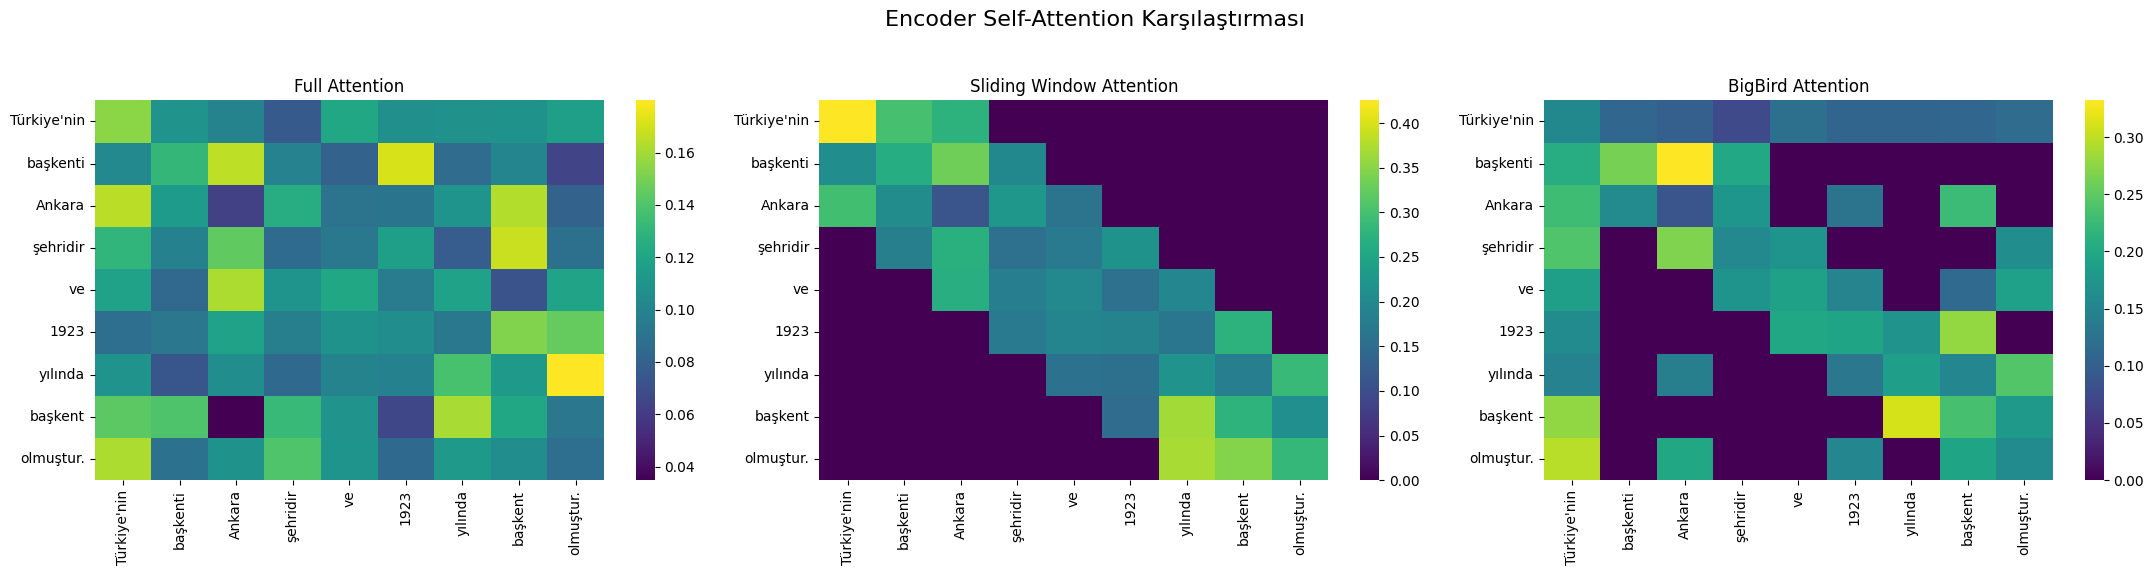


>>> FlashAttention Notu: YukarÄ±daki dikkat matrislerinden herhangi biri, hesaplama sÄ±rasÄ±nda
    GPU'nun yavaÅŸ HBM'i yerine hÄ±zlÄ± SRAM'ini kullanan FlashAttention algoritmasÄ± ile
    Ã§ok daha hÄ±zlÄ± bir ÅŸekilde (sonuÃ§ deÄŸiÅŸmeden) hesaplanabilir.

SimÃ¼lasyonun devamÄ± iÃ§in BigBird Attention Ã§Ä±ktÄ±sÄ± seÃ§ildi.

--- AdÄ±m 3: Feed-Forward Network (FFN) ---
Attention katmanÄ±ndan gelen bilgi, FFN katmanÄ±nda 'iÅŸlenir' ve zenginleÅŸtirilir.
Standart FFN: TÃ¼m parametreler her token iÃ§in kullanÄ±lÄ±r. Maliyetli ama basittir.
Mixture of Experts: Her token iÃ§in sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) Ã§alÄ±ÅŸÄ±r.
                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.
SimÃ¼lasyonun devamÄ± iÃ§in MoE FFN Ã§Ä±ktÄ±sÄ± seÃ§ildi.

===> ENCODER AÅžAMASI TAMAMLANDI. BaÄŸlamÄ±n anlamsal temsili hazÄ±r.


============================== DECODER AÅžAMASI ==============================
AmaÃ§: Soruyu ve iÅŸlenmiÅŸ baÄŸlamÄ± kullanarak cevabÄ± kelime kelime 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# =============================================================================
# BÃ–LÃœM 1: YARDIMCI FONKSÄ°YONLAR VE MODÃœLLER
# Ã–nceki kodlarÄ±mÄ±zdan bildiÄŸimiz yapÄ± taÅŸlarÄ±nÄ± oluÅŸturalÄ±m.
# =============================================================================

# --- Maske oluÅŸturma fonksiyonlarÄ± ---
def create_sliding_window_mask(size, window):
    mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        start, end = max(0, i - window), min(size, i + window + 1)
        mask[i, start:end] = 0
    return mask

def create_bigbird_mask(size, window, num_random, global_indices):
    # BigBird, 3 maskenin birleÅŸimidir
    window_mask = create_sliding_window_mask(size, window)
    
    random_mask = torch.full((size, size), float('-inf'))
    for i in range(size):
        random_indices = np.random.choice(size, num_random, replace=False)
        random_mask[i, random_indices] = 0
    
    global_mask = torch.full((size, size), float('-inf'))
    global_mask[global_indices, :] = 0
    global_mask[:, global_indices] = 0
    
    # 3 maskeyi birleÅŸtir (herhangi biri izin veriyorsa, geÃ§iÅŸe izin ver)
    combined_mask = torch.maximum(torch.maximum(window_mask, random_mask), global_mask)
    return combined_mask

# --- Dikkat ve FFN ModÃ¼lleri ---
class Attention(nn.Module):
    def __init__(self, dim, n_heads=2):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            scores += mask.to(scores.device)
        
        weights = F.softmax(scores, dim=-1)
        attended = (weights @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(attended), weights

class StandardFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim * 4)
        self.fc2 = nn.Linear(dim * 4, dim)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# --- MoE ModÃ¼lleri ---
class Expert(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = StandardFFN(dim)
    def forward(self, x):
        return self.net(x)

class MoELayer(nn.Module):
    def __init__(self, dim, num_experts=4, top_k=2):
        super().__init__()
        self.experts = nn.ModuleList([Expert(dim) for _ in range(num_experts)])
        self.gating = nn.Linear(dim, num_experts)
        self.top_k = top_k
    
    def forward(self, x):
        # Sadece konsepti gÃ¶stermek iÃ§in basitleÅŸtirilmiÅŸ forward pass
        logits = self.gating(x)
        top_k_logits, top_k_indices = torch.topk(logits, self.top_k, dim=-1)
        weights = F.softmax(top_k_logits, dim=-1)
        
        output = torch.zeros_like(x)
        for i in range(x.size(0)): # Batch
            for j in range(x.size(1)): # Sequence
                token_input = x[i, j]
                for k in range(self.top_k):
                    expert_idx = top_k_indices[i, j, k].item()
                    weight = weights[i, j, k]
                    output[i, j] += weight * self.experts[expert_idx](token_input)
        return output

# =============================================================================
# BÃ–LÃœM 2: UÃ‡TAN UCA SÄ°MÃœLASYON
# =============================================================================
def run_qa_simulation():
    print("="*80)
    print(" " * 15 + "UÃ‡TAN UCA SORU-CEVAP MODELÄ° SÄ°MÃœLASYONU")
    print("="*80)
    
    # --- GÄ°RDÄ°LER ---
    context = "TÃ¼rkiye'nin baÅŸkenti Ankara ÅŸehridir ve 1923 yÄ±lÄ±nda baÅŸkent olmuÅŸtur."
    question = "Ankara ne zaman baÅŸkent oldu?"
    
    # TokenleÅŸtirme (basitÃ§e kelimelere ayÄ±rma)
    # GerÃ§ekte [CLS], [SEP] gibi Ã¶zel tokenlar da eklenir.
    context_tokens = context.split()
    question_tokens = question.split()
    vocab = sorted(list(set(context_tokens + question_tokens)))
    token_to_id = {t: i for i, t in enumerate(vocab)}
    
    context_ids = torch.tensor([token_to_id[t] for t in context_tokens])
    question_ids = torch.tensor([token_to_id[t] for t in question_tokens])
    
    # --- MODEL PARAMETRELERÄ° ---
    dim = 32 # VektÃ¶r boyutu
    vocab_size = len(vocab)
    
    # Model bileÅŸenlerini oluÅŸtur
    embedding = nn.Embedding(vocab_size, dim)
    encoder_attention = Attention(dim)
    encoder_ffn = StandardFFN(dim)
    encoder_moe = MoELayer(dim, num_experts=4, top_k=2)
    
    # --- AdÄ±m 1: GÃ¶mme (Embedding) ---
    print("\n--- AdÄ±m 1: Girdileri VektÃ¶rlere DÃ¶nÃ¼ÅŸtÃ¼rme (Embedding) ---")
    context_embeds = embedding(context_ids).unsqueeze(0) # (1, seq_len, dim)
    question_embeds = embedding(question_ids).unsqueeze(0)
    print(f"BaÄŸlam '{context}' {context_embeds.shape} boyutlu bir tensÃ¶re dÃ¶nÃ¼ÅŸtÃ¼rÃ¼ldÃ¼.")
    print(f"Soru '{question}' {question_embeds.shape} boyutlu bir tensÃ¶re dÃ¶nÃ¼ÅŸtÃ¼rÃ¼ldÃ¼.")

    # =========================================================================
    # BÃ–LÃœM 3: ENCODER (ANLAMA) AÅžAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " ENCODER AÅžAMASI " + "="*30)
    print("AmaÃ§: BaÄŸlam cÃ¼mlesinin zengin bir anlamsal temsilini oluÅŸturmak.\n")

    # --- AdÄ±m 2: Self-Attention KarÅŸÄ±laÅŸtÄ±rmasÄ± ---
    print("\n--- AdÄ±m 2: Self-Attention (Ã–z-Dikkat) ---")
    print("Encoder, baÄŸlamdaki her kelimenin diÄŸer kelimelerle iliÅŸkisini tartar.")

    # 2a: Full Attention
    full_att_output, full_weights = encoder_attention(context_embeds)
    
    # 2b: Sliding Window Attention
    seq_len = context_embeds.shape[1]
    window_mask = create_sliding_window_mask(seq_len, window=2)
    window_att_output, window_weights = encoder_attention(context_embeds, mask=window_mask)
    
    # 2c: BigBird Attention
    bigbird_mask = create_bigbird_mask(seq_len, window=1, num_random=2, global_indices=[0])
    bigbird_att_output, bigbird_weights = encoder_attention(context_embeds, mask=bigbird_mask)

    # GÃ¶rselleÅŸtirme
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    sns.heatmap(full_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[0], cmap='viridis').set_title("Full Attention")
    sns.heatmap(window_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[1], cmap='viridis').set_title("Sliding Window Attention")
    sns.heatmap(bigbird_weights[0,0].detach(), xticklabels=context_tokens, yticklabels=context_tokens, ax=axes[2], cmap='viridis').set_title("BigBird Attention")
    fig.suptitle("Encoder Self-Attention KarÅŸÄ±laÅŸtÄ±rmasÄ±", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\n>>> FlashAttention Notu: YukarÄ±daki dikkat matrislerinden herhangi biri, hesaplama sÄ±rasÄ±nda")
    print("    GPU'nun yavaÅŸ HBM'i yerine hÄ±zlÄ± SRAM'ini kullanan FlashAttention algoritmasÄ± ile")
    print("    Ã§ok daha hÄ±zlÄ± bir ÅŸekilde (sonuÃ§ deÄŸiÅŸmeden) hesaplanabilir.\n")
    
    # SimÃ¼lasyonun devamÄ± iÃ§in en geliÅŸmiÅŸ olan BigBird Ã§Ä±ktÄ±sÄ±nÄ± kullanalÄ±m
    encoder_att_output = bigbird_att_output
    print("SimÃ¼lasyonun devamÄ± iÃ§in BigBird Attention Ã§Ä±ktÄ±sÄ± seÃ§ildi.")

    # --- AdÄ±m 3: Feed-Forward ve MoE KarÅŸÄ±laÅŸtÄ±rmasÄ± ---
    print("\n--- AdÄ±m 3: Feed-Forward Network (FFN) ---")
    print("Attention katmanÄ±ndan gelen bilgi, FFN katmanÄ±nda 'iÅŸlenir' ve zenginleÅŸtirilir.")
    
    # 3a: Standart FFN
    ffn_output = encoder_ffn(encoder_att_output)
    print("Standart FFN: TÃ¼m parametreler her token iÃ§in kullanÄ±lÄ±r. Maliyetli ama basittir.")
    
    # 3b: Mixture of Experts (MoE) FFN
    moe_output = encoder_moe(encoder_att_output)
    print("Mixture of Experts: Her token iÃ§in sadece en iyi 'k' uzman (toplam 4 uzmandan 2'si) Ã§alÄ±ÅŸÄ±r.")
    print("                  Daha fazla kapasite, daha az hesaplama maliyeti demektir.")

    # SimÃ¼lasyonun devamÄ± iÃ§in MoE Ã§Ä±ktÄ±sÄ±nÄ± kullanalÄ±m
    final_encoder_output = moe_output
    print("SimÃ¼lasyonun devamÄ± iÃ§in MoE FFN Ã§Ä±ktÄ±sÄ± seÃ§ildi.")
    print("\n===> ENCODER AÅžAMASI TAMAMLANDI. BaÄŸlamÄ±n anlamsal temsili hazÄ±r.")

    # =========================================================================
    # BÃ–LÃœM 4: DECODER (CEVAP ÃœRETME) AÅžAMASI
    # =========================================================================
    print("\n\n" + "="*30 + " DECODER AÅžAMASI " + "="*30)
    print("AmaÃ§: Soruyu ve iÅŸlenmiÅŸ baÄŸlamÄ± kullanarak cevabÄ± kelime kelime Ã¼retmek.\n")
    
    decoder_output_tokens = []
    # Decoder'Ä± [START] token'Ä± gibi Ã¶zel bir token ile baÅŸlatalÄ±m
    # Basitlik iÃ§in sorunun ilk kelimesini kullanalÄ±m
    decoder_input_ids = torch.tensor([token_to_id[question_tokens[0]]]).unsqueeze(0)
    
    for i in range(4): # 4 kelimelik bir cevap Ã¼retelim
        print(f"\n--- AdÄ±m 4.{i+1}: CevabÄ±n {i+1}. Kelimesi Ãœretiliyor ---")
        decoder_embeds = embedding(decoder_input_ids)
        
        # 4a: Decoder Self-Attention (Maskeli)
        # Decoder, cevap Ã¼retirken gelecekteki kelimelere bakamaz.
        size = decoder_embeds.shape[1]
        decoder_mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1)
        # ... Bu maske ile self-attention yapÄ±lÄ±r ...
        
        # 4b: Cross-Attention
        # Bu en Ã¶nemli adÄ±mdÄ±r: Decoder, Encoder'Ä±n Ã§Ä±ktÄ±sÄ±na "bakar".
        print(f"  Cross-Attention: Ãœretilen kelimeler ('{decoder_output_tokens}'), baÄŸlama ('...{context_tokens[-3:]}') bakÄ±yor.")
        # SimÃ¼lasyon: Decoder'Ä±n son durumu ile Encoder'Ä±n Ã§Ä±ktÄ±sÄ± arasÄ±nda dikkat hesaplanÄ±r.
        # GerÃ§ekte bu ayrÄ± bir attention katmanÄ±dÄ±r.
        cross_attention_output, cross_weights = encoder_attention(decoder_embeds, mask=None) # Q=decoder, K,V=encoder
        
        # 4c: Decoder FFN
        # ... Cross-attention'dan gelen bilgi FFN'de iÅŸlenir ...
        
        # 4d: Son Kelimeyi Tahmin Etme
        # Son katmandan gelen vektÃ¶r, tÃ¼m kelime daÄŸarcÄ±ÄŸÄ± Ã¼zerine bir olasÄ±lÄ±k daÄŸÄ±lÄ±mÄ±na dÃ¶nÃ¼ÅŸtÃ¼rÃ¼lÃ¼r.
        final_logits = torch.randn(1, 1, vocab_size) # SimÃ¼lasyon
        next_token_id = torch.argmax(final_logits, dim=-1).item()
        next_token = vocab[next_token_id]
        decoder_output_tokens.append(next_token)
        
        print(f"  Tahmin: Model, bir sonraki kelimenin '{next_token}' olacaÄŸÄ±na karar verdi.")
        
        # Ãœretilen yeni kelimeyi bir sonraki adÄ±mÄ±n girdisi yap
        new_input_id = torch.tensor([[next_token_id]])
        decoder_input_ids = torch.cat([decoder_input_ids, new_input_id], dim=1)

    print("\n===> DECODER AÅžAMASI TAMAMLANDI.")
    print(f"\nNihai Ãœretilen Cevap (AnlamsÄ±z olabilir): '{' '.join(decoder_output_tokens)}'")
    
    # =========================================================================
    # BÃ–LÃœM 5: TEKNÄ°K Ã–ZET VE KARÅžILAÅžTIRMA
    # =========================================================================
    print("\n\n" + "="*25 + " TÃœM TEKNÄ°KLERÄ°N Ã–ZETÄ° " + "="*25)
    summary = {
        "Full Attention": {
            "AmaÃ§": "Her kelimenin diÄŸer her kelimeyle iliÅŸkisini tam olarak hesaplamak.",
            "Avantaj": "Maksimum baÄŸlamsal bilgi, en yÃ¼ksek potansiyel doÄŸruluk.",
            "Dezavantaj": "Uzun metinlerde Ã§ok yavaÅŸ ve hafÄ±za tÃ¼ketimi yÃ¼ksek (O(NÂ²))."
        },
        "Sparse Attention (Window/BigBird)": {
            "AmaÃ§": "Hesaplama maliyetini dÃ¼ÅŸÃ¼rmek iÃ§in her kelimenin sadece bir alt kÃ¼meye dikkat etmesini saÄŸlamak.",
            "Avantaj": "Ã‡ok daha hÄ±zlÄ± ve verimli (O(N) veya O(N log N)), uzun metinleri iÅŸleyebilir.",
            "Dezavantaj": "Teorik olarak bazÄ± Ã¶nemli uzun mesafeli iliÅŸkileri kaÃ§Ä±rma riski taÅŸÄ±r."
        },
        "FlashAttention": {
            "AmaÃ§": "HesaplamayÄ± deÄŸiÅŸtirmeden, GPU hafÄ±za (HBM/SRAM) eriÅŸimini optimize ederek sÃ¼reci hÄ±zlandÄ±rmak.",
            "Avantaj": "Full Attention ile matematiksel olarak aynÄ± sonucu Ã§ok daha hÄ±zlÄ± Ã¼retir. YaklaÅŸÄ±m deÄŸildir.",
            "Dezavantaj": "UygulamasÄ± karmaÅŸÄ±ktÄ±r, dÃ¼ÅŸÃ¼k seviye donanÄ±m bilgisi gerektirir."
        },
        "Mixture of Experts (MoE)": {
            "AmaÃ§": "Modelin parametre sayÄ±sÄ±nÄ± (kapasitesini) hesaplama maliyetini artÄ±rmadan devasa boyutlara Ã§Ä±karmak.",
            "Avantaj": "Daha 'bilgili' ve yetenekli modelleri, daha hÄ±zlÄ± eÄŸitim/Ã§Ä±karÄ±m sÃ¼releriyle mÃ¼mkÃ¼n kÄ±lar.",
            "Dezavantaj": "EÄŸitimi daha karmaÅŸÄ±k ve kararsÄ±z olabilir, daha fazla VRAM gerektirir."
        }
    }
    for tech, details in summary.items():
        print(f"\n--- {tech} ---")
        for key, value in details.items():
            print(f"  {key}: {value}")

if __name__ == '__main__':
    # SimÃ¼lasyonu Ã§alÄ±ÅŸtÄ±r
    run_qa_simulation()